In [7]:
import numpy as np
import control.matlab as ct
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [8]:
# --- System Physical Parameters ---
# Gravitational acceleration (m/s^2)
g = 9.81

# Stem Parameters
M_stem = 0.006      # Mass (kg)
H_stem = 0.044      # Height (m)
W_stem = 0.006      # Width (m)

# Body Parameters
M_body = 0.048      # Mass (kg)
H_body = 0.095      # Height (m)
W_body = 0.054      # Width (m)

# Wheel Parameters
M_wheel = 0.10933   # Mass (kg)
D_wheel_out = 0.126 # Outer diameter (m)
D_wheel_in = 0.104  # Inner diameter (m)

# --- Motor Parameters ---
M_motor = 0.11233   # Mass (kg)
D_motor = 0.042     # Diameter (m) (2 * motor_radius)
V_s = 12.0          # Supply Voltage (V)
R = 0.4             # Terminal Resistance (Ohms)
L = 1.2e-3          # Terminal Inductance (H) - Ignored in the simplified torque model
Kt = 0.04           # Torque Constant (N*m/A)
Ke = 0.04           # Back-EMF Constant (V*s/rad)

In [9]:
# --- 1. Calculate Moments of Inertia ---

# Wheel inertia about its rotational axis (hollow cylinder)
I_w = 0.5 * M_wheel * ((D_wheel_out/2)**2 + (D_wheel_in/2)**2)

# Inertia of individual components about their own center of mass
# Rectangular prism formula: I_cm = (1/12) * M * (h^2 + w^2)
I_stem_cm = (1/12) * M_stem * (H_stem**2 + W_stem**2)
I_body_cm = (1/12) * M_body * (H_body**2 + W_body**2)
# Solid cylinder formula for motor: I_cm = 0.5 * M * r^2
I_motor_cm = 0.5 * M_motor * (D_motor/2)**2

# Distances from pivot to each component's center of mass
d_stem = H_stem / 2
d_body = H_stem + (H_body / 2)
d_motor = H_stem + H_body + (D_motor / 2)

# Total pendulum inertia about the pivot point using Parallel Axis Theorem
# I = I_cm + m*d^2
I_p = (I_stem_cm + M_stem * d_stem**2) + \
      (I_body_cm + M_body * d_body**2) + \
      (I_motor_cm + M_motor * d_motor**2) + \
      (M_wheel * d_motor**2)

# --- 2. Calculate Combined Center of Mass ---
M_total = M_stem + M_body + M_motor + M_wheel
h_com = (M_stem*d_stem + M_body*d_body + (M_motor + M_wheel)*d_motor) / M_total

# --- 3. Construct State-Space Matrices A and B ---
# Intermediate constants from the derived model
C1 = M_total * g * h_com
C2 = (Kt * Ke) / R
C3 = (Kt * V_s) / R

# State-space matrix A
A = np.array([
    [0,        1,         0,           0],
    [C1 / I_p, 0,         0,      C2 / I_p],
    [0,        0,         0,           1],
    [-C1 / I_p, 0,        0, -C2 * (I_p + I_w) / (I_p * I_w)]
])

# State-space matrix B
B = np.array([
    [0],
    [-C3 / I_p],
    [0],
    [C3 * (I_p + I_w) / (I_p * I_w)]
])

# Output matrix C (to observe all states) and feedthrough matrix D
C = np.identity(4)
D = np.zeros((4, 1))

# Create the state-space system object
sys = ct.ss(A, B, C, D)

print("System Matrix A:\n", A)
print("\nInput Matrix B:\n", B)

System Matrix A:
 [[  0.           1.           0.           0.        ]
 [ 63.75939732   0.           0.           0.65011192]
 [  0.           0.           0.           1.        ]
 [-63.75939732   0.           0.         -11.61563905]]

Input Matrix B:
 [[   0.        ]
 [-195.03357516]
 [   0.        ]
 [3484.69171649]]


In [10]:
# LQR weighting matrices
# Q penalizes state errors [theta_p, theta_p_dot, theta_w, theta_w_dot]
Q = np.diag([20.0, 1.0, 0.0, 0.1])

# R penalizes control input u (PWM)
R = np.array([[0.1]])

# Calculate the optimal LQR gain matrix K
K, S, E = ct.lqr(sys, Q, R)

print("Optimal LQR Gain Matrix K:\n", K)

# Create the closed-loop system
A_cl = A - B @ K
sys_cl = ct.ss(A_cl, B, C, D)

Optimal LQR Gain Matrix K:
 [[-2.79302990e+02 -3.60909111e+01 -5.05365907e-14 -1.00333889e+00]]


In [11]:
# Simulation parameters
t_span = (0, 10) # Time span for simulation (0 to 10 seconds)
t_eval = np.linspace(t_span[0], t_span[1], 1000) # Time points for evaluation
x0 = np.array([np.deg2rad(5), 0, 0, 0]) # Initial state: 5-degree tilt, zero velocity

# --- Simulate the Uncontrolled (Open-Loop) System ---
def open_loop_dynamics(t, x):
    return A @ x

sol_open_loop = solve_ivp(open_loop_dynamics, t_span, x0, t_eval=t_eval, dense_output=True)
x_open_loop = sol_open_loop.y

# --- Simulate the Controlled (Closed-Loop) System ---
def closed_loop_dynamics(t, x):
    return A_cl @ x

sol_closed_loop = solve_ivp(closed_loop_dynamics, t_span, x0, t_eval=t_eval, dense_output=True)
x_closed_loop = sol_closed_loop.y

# Calculate the control input u(t) over time for the closed-loop case
u_closed_loop = -K @ x_closed_loop

In [12]:
# Discretize the continuous-time LQR controller

# Define the sampling time (e.g., 10 ms)
dt = 0.01

# Discretize the state-space system
sysd = ct.c2d(sys, dt)

# Discretize the LQR gain using the discrete-time system
K_d, S_d, E_d = ct.dlqr(sysd.A, sysd.B, Q, R)

print("Discrete-time LQR Gain Matrix K_d:\n", K_d)

Discrete-time LQR Gain Matrix K_d:
 [[-8.35843438e+00 -1.07745285e+00  8.18723553e-18 -3.10273526e-02]]


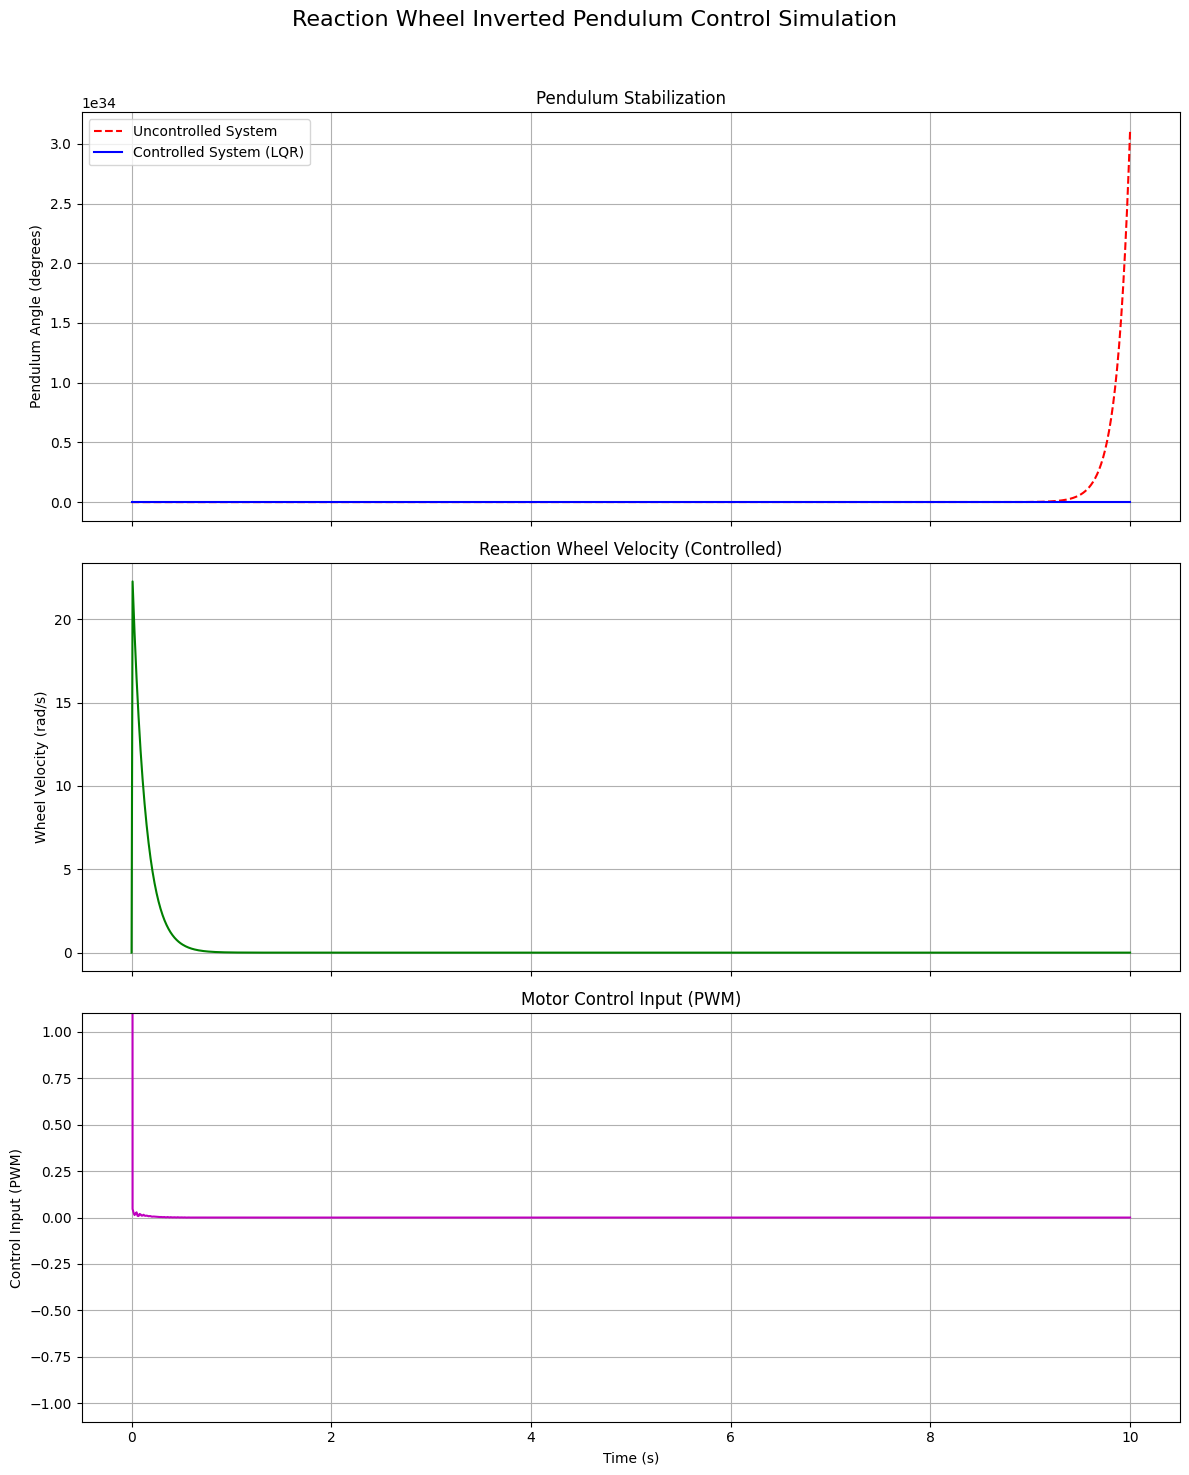

In [13]:
# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Reaction Wheel Inverted Pendulum Control Simulation', fontsize=16)

# --- Plot 1: Pendulum Angle ---
axs[0].plot(t_eval, np.rad2deg(x_open_loop[0, :]), 'r--', label='Uncontrolled System')
axs[0].plot(t_eval, np.rad2deg(x_closed_loop[0, :]), 'b-', label='Controlled System (LQR)')
axs[0].set_ylabel('Pendulum Angle (degrees)')
axs[0].set_title('Pendulum Stabilization')
axs[0].legend()
axs[0].grid(True)

# --- Plot 2: Wheel Angular Velocity ---
axs[1].plot(t_eval, x_closed_loop[3, :], 'g-')
axs[1].set_ylabel('Wheel Velocity (rad/s)')
axs[1].set_title('Reaction Wheel Velocity (Controlled)')
axs[1].grid(True)

# --- Plot 3: Control Input (PWM) ---
axs[2].plot(t_eval, u_closed_loop[0, :], 'm-')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Control Input (PWM)')
axs[2].set_title('Motor Control Input (PWM)')
axs[2].set_ylim([-1.1, 1.1]) # Clamp PWM view to [-1, 1] range
axs[2].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()